In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import time
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mapie.multi_label_classification import MapieMultiLabelClassifier
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/polyp"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/polyp/03_model_weights/resnet"
MODEL_NAME = "20240325_1446"

In [5]:
# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [6]:
IMG_SIZE = 64
RESNET_EMBEDDING_SIZE = config["model"]["embedding_size"]


In [7]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_CAL_IMAGES = os.path.join(BASE_DIR, "02_prepared_data/cal/images")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")
DIR_TEST_IMAGES = DIR_CAL_IMAGES.replace("cal", "test")

DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")


In [8]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), RESNET_EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(
        tqdm(zip(
            sorted(os.listdir(pred_probas_dir)),
            sorted(os.listdir(res_emb_dir)),
            sorted(os.listdir(labels_dir))
        ))
    ):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [9]:
cal_pred_probas, cal_res_emb, cal_labels = load_data(
    DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS
)


0it [00:00, ?it/s]

252it [00:00, 798.66it/s] 


In [10]:
test_pred_probas, test_res_emb, test_labels = load_data(
    DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS
)

546it [00:00, 834.76it/s] 


In [11]:
index_not_empy = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
cal_labels = cal_labels[index_not_empy]
cal_res_emb = cal_res_emb[index_not_empy]
cal_pred_probas = cal_pred_probas[index_not_empy]


In [12]:
cal_res_emb = np.concatenate([np.ones((cal_res_emb.shape[0], 1)), cal_res_emb], axis=1)
test_res_emb = np.concatenate([np.ones((test_res_emb.shape[0], 1)), test_res_emb], axis=1)

RESNET_EMBEDDING_SIZE += 1

In [13]:
ALPHA = .1
N = len(cal_labels)
REGULARIZATION = "ridge"

# Fit CRC

In [14]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [15]:
mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
mapie_crc.lambdas = np.arange(0, 1, 0.001)
for i in tqdm(range(len(cal_pred_probas))):
    X, y = cal_pred_probas[i], cal_labels[i]
    mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])

100%|██████████| 252/252 [00:04<00:00, 52.35it/s]


In [16]:
_, _ = mapie_crc.predict(test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
th_crc = mapie_crc.lambdas_star
th_crc

array([0.276])

In [17]:
mapie_crc.risks.shape

(252, 1000)

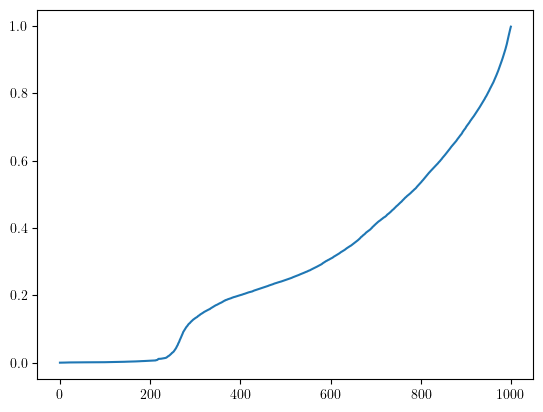

In [18]:
plt.plot(mapie_crc.risks.mean(axis=0))

# Fit multi-accurate with ResNet embedding

In [19]:
lambda_resnet = .01
result_res = minimize(
    J, np.random.uniform(0, 1, RESNET_EMBEDDING_SIZE),
    method="SLSQP",
    args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, N, REGULARIZATION, lambda_resnet), jac=J_prime,
    options={"disp": True, "maxiter": 1000}, tol=1e-10
)
ths_res = (test_res_emb @ result_res.x).reshape(-1, 1, 1)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.629059832695235
            Iterations: 39
            Function evaluations: 92
            Gradient evaluations: 39


# Apply thresholds on pred-probas

In [20]:
y_pred_test_th_resnet = (test_pred_probas >= ths_res).astype(int)
recall_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

y_pred_test_th_crc = (test_pred_probas >= th_crc).astype(int)
recall_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

In [21]:
precision_test_resnet = np.nan_to_num((y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2)), nan=1)
precision_test_crc = np.nan_to_num((y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2)), nan=1)


/tmp/ipykernel_4134426/1638778521.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test_resnet = np.nan_to_num((y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2)), nan=1)


# Plot results

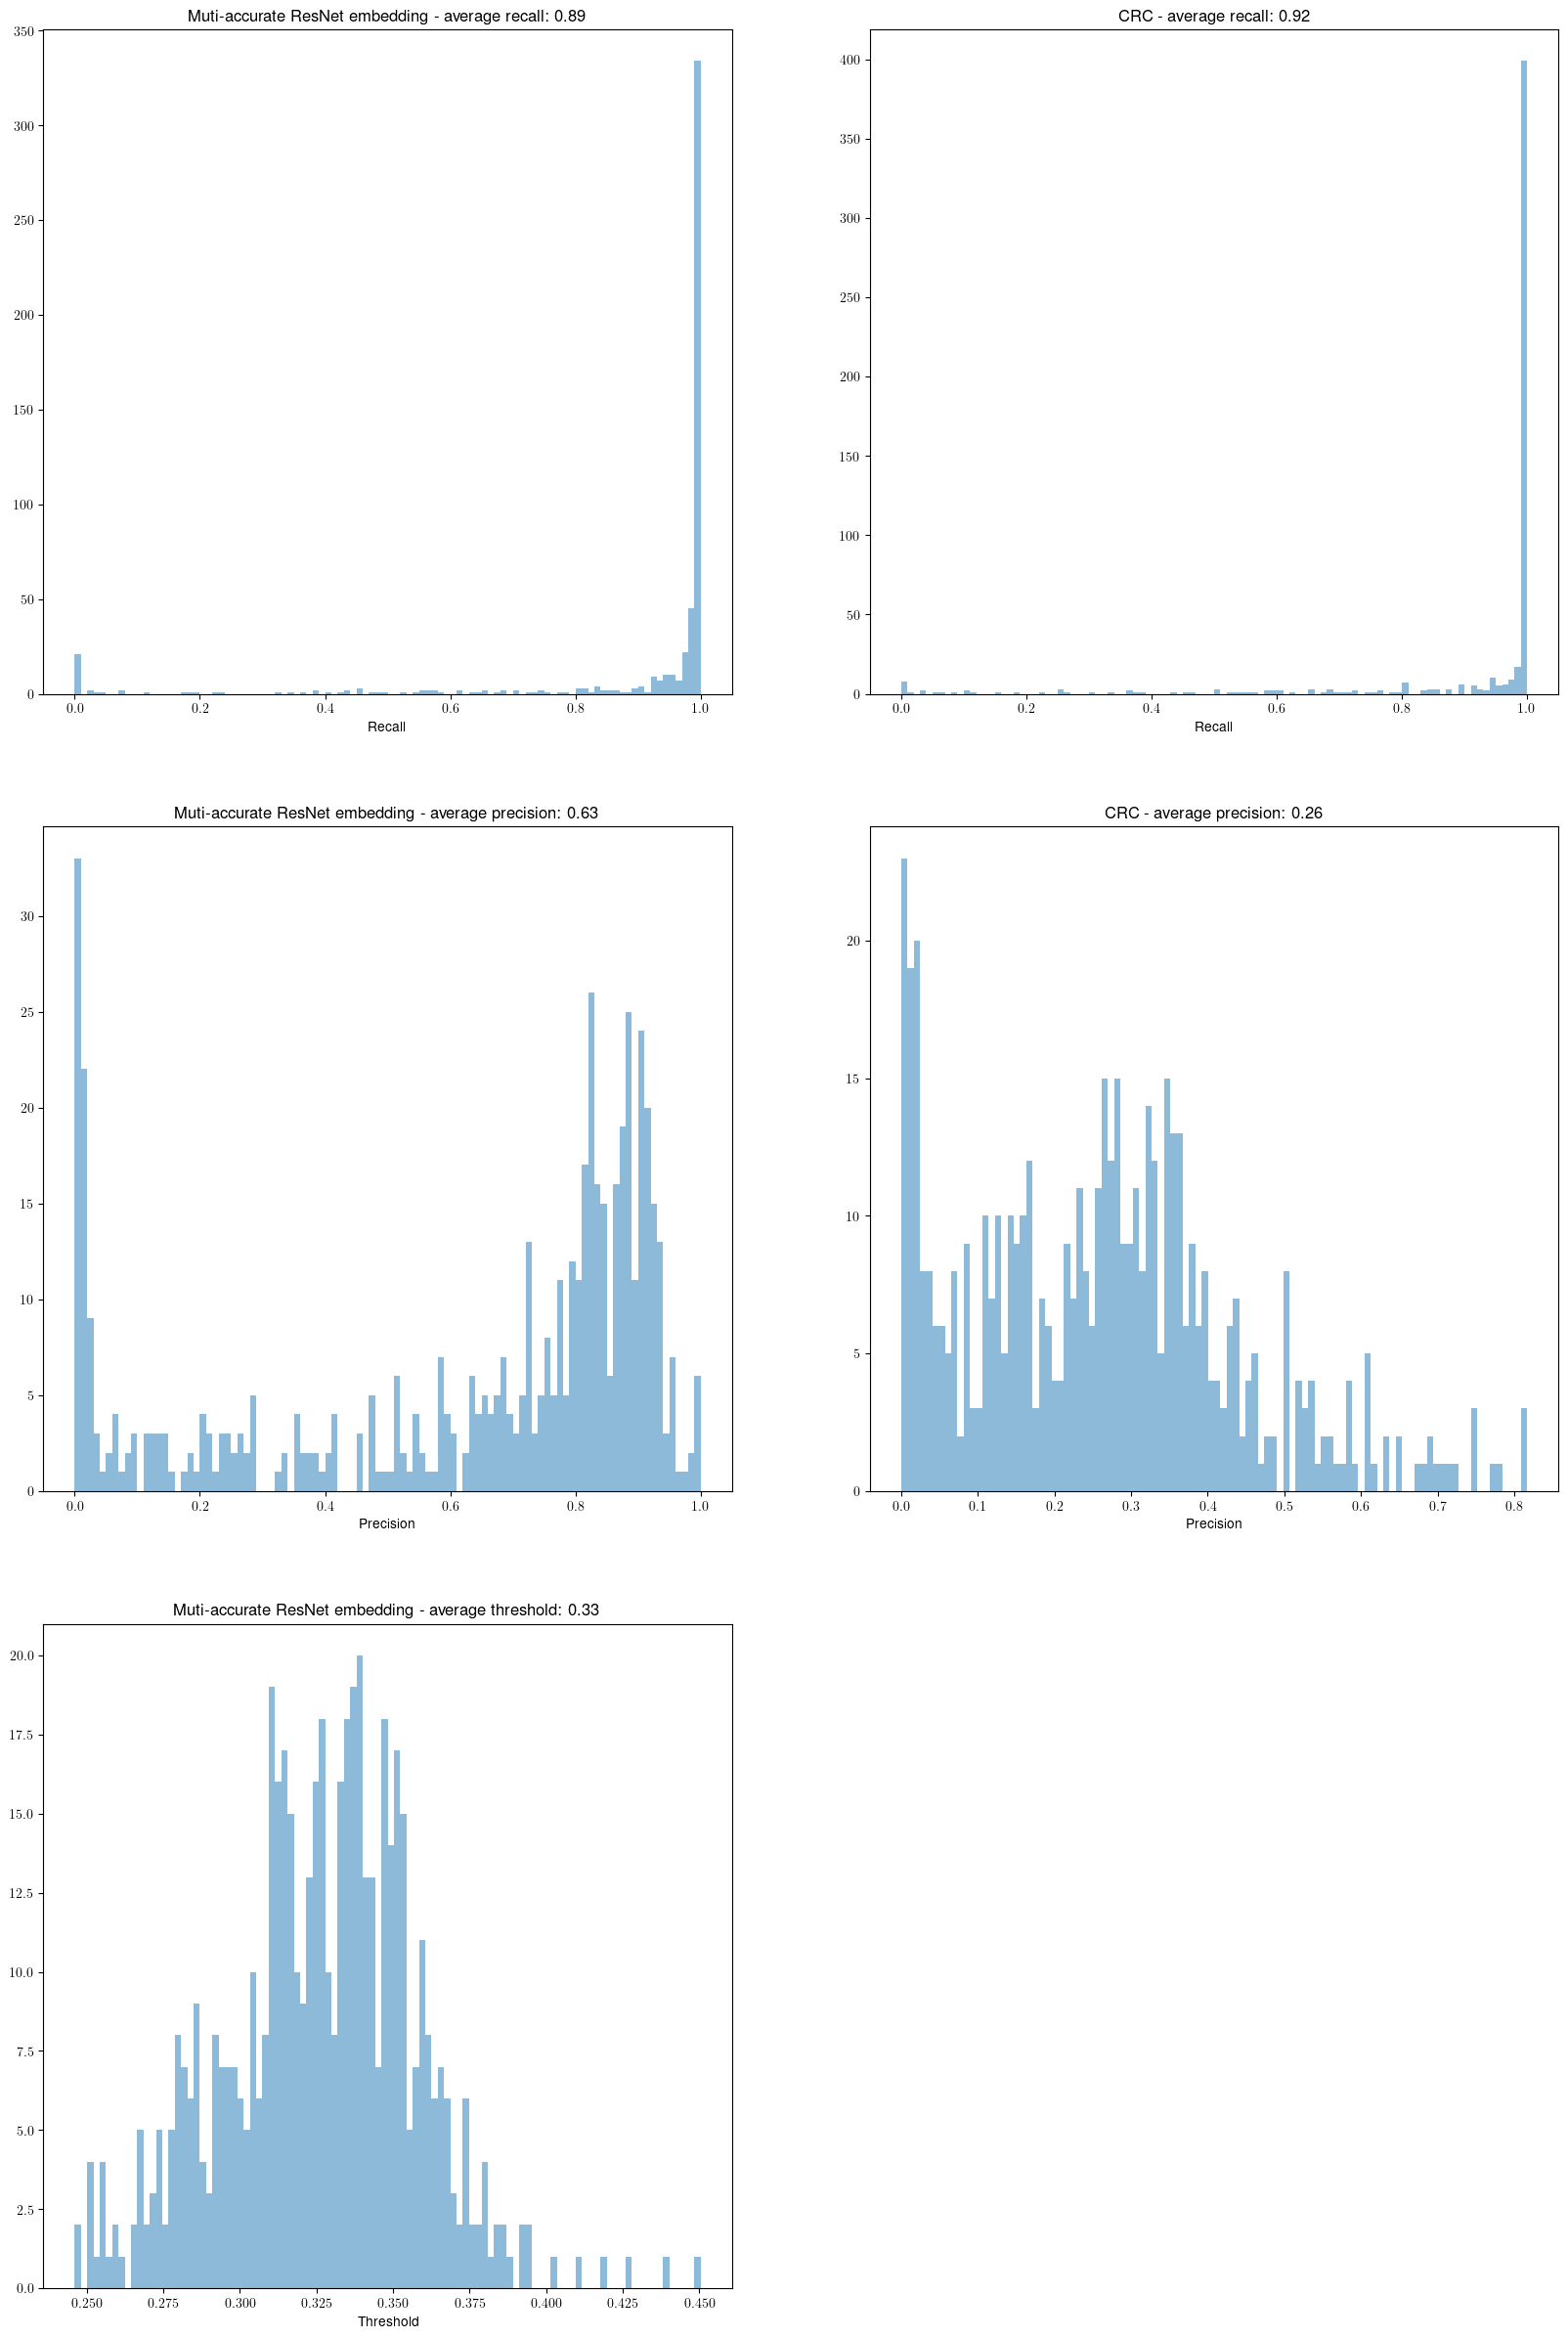

In [22]:
s = 10
nrow = 3
ncol = 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s))

ax[0, 0].hist(recall_resnet, bins=100, alpha=.5)
ax[0, 0].set_title(f"Muti-accurate ResNet embedding - average recall: {np.nanmean(recall_resnet):.2f}")
ax[0, 0].set_xlabel("Recall")

ax[0, 1].hist(recall_test_crc, bins=100, alpha=.5)
ax[0, 1].set_title(f"CRC - average recall: {np.nanmean(recall_test_crc):.2f}")
ax[0, 1].set_xlabel("Recall")

ax[1, 0].hist(precision_test_resnet, bins=100, alpha=.5)
ax[1, 0].set_title(f"Muti-accurate ResNet embedding - average precision: {np.nanmean(precision_test_resnet):.2f}")
ax[1, 0].set_xlabel("Precision")

ax[1, 1].hist(precision_test_crc, bins=100, alpha=.5)
ax[1, 1].set_title(f"CRC - average precision: {np.nanmean(precision_test_crc):.2f}")
ax[1, 1].set_xlabel("Precision")


ax[2, 0].hist(ths_res[:, 0, 0], bins=100, alpha=.5)
ax[2, 0].set_title(f"Muti-accurate ResNet embedding - average threshold: {np.nanmean(ths_res):.2f}")
ax[2, 0].set_xlabel("Threshold")

ax[2, 1].set_axis_off()

In [23]:
# s = 3
# for i in range(20):
#     arg = np.argsort(ths_res[:, 0, 0])[270+i]
#     f, ax = plt.subplots(1, 4, figsize=(4 * s, s))
#     img_arg = cv2.imread(os.path.join(DIR_TEST_IMAGES, sorted(os.listdir(DIR_TEST_IMAGES))[arg]))
#     ax[0].imshow(img_arg)
#     labels_arg = cv2.imread(os.path.join(DIR_TEST_LABELS, sorted(os.listdir(DIR_TEST_LABELS))[arg]), cv2.IMREAD_GRAYSCALE)
#     pred_proba_arg = np.load(os.path.join(DIR_TEST_PRED_PROBAS, sorted(os.listdir(DIR_TEST_PRED_PROBAS))[arg]))
#     ax[1].imshow(labels_arg)
#     ax[2].imshow(pred_proba_arg)
#     ax[3].imshow(pred_proba_arg >= ths_res[arg])
#     ax[0].set_title(arg)
#     plt.show()




In [24]:
# hard_img_id = 271
# izy_img_id = np.argsort(ths_res[:, 0, 0])[-2]
# s = 10
# f, ax = plt.subplots(2, 3, figsize=(4 * s,2 * s))
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# hard_img = cv2.imread(os.path.join(DIR_TEST_IMAGES, sorted(os.listdir(DIR_TEST_IMAGES))[hard_img_id]))
# hard_img = cv2.cvtColor(hard_img, cv2.COLOR_BGR2RGB)
# pred_proba_hard = np.load(os.path.join(DIR_TEST_PRED_PROBAS, sorted(os.listdir(DIR_TEST_PRED_PROBAS))[hard_img_id]))
# hard_label = cv2.imread(os.path.join(DIR_TEST_LABELS, sorted(os.listdir(DIR_TEST_LABELS))[hard_img_id]), cv2.IMREAD_GRAYSCALE) // 255
# pred_th_hard = pred_proba_hard >= ths_res[hard_img_id]

# izy_img = cv2.imread(os.path.join(DIR_TEST_IMAGES, sorted(os.listdir(DIR_TEST_IMAGES))[izy_img_id]))
# izy_img = cv2.cvtColor(izy_img, cv2.COLOR_BGR2RGB)
# pred_proba_izy = np.load(os.path.join(DIR_TEST_PRED_PROBAS, sorted(os.listdir(DIR_TEST_PRED_PROBAS))[izy_img_id]))
# izy_label = cv2.imread(os.path.join(DIR_TEST_LABELS, sorted(os.listdir(DIR_TEST_LABELS))[izy_img_id]), cv2.IMREAD_GRAYSCALE)

# #resize izy image to hard image shape
# izy_img = cv2.resize(izy_img, (hard_img.shape[1], hard_img.shape[0]))
# izy_label = cv2.resize(izy_label, (hard_img.shape[1], hard_img.shape[0])) // 255
# pred_proba_izy = cv2.resize(pred_proba_izy, (hard_img.shape[1], hard_img.shape[0]))

# pred_th_izy = pred_proba_izy >= ths_res[izy_img_id]

# pred_plot_hard = np.zeros((hard_img.shape[0], hard_img.shape[1], 3)).astype(int)
# pred_plot_izt = np.zeros((izy_img.shape[0], izy_img.shape[1], 3)).astype(int)

# # tp_crc = pred_th_crc * label
# # fp_crc = pred_th_crc * (1 - label)
# # fn_crc = (1 - pred_th_crc) * label
# # pred_plot_crc[tp_crc == 1] = [255, 255, 255]
# # pred_plot_crc[fp_crc == 1] = [0, 255, 255]
# # pred_plot_crc[fn_crc == 1] = [255, 0, 0]

# # tp_res = pred_th_res * label
# # fp_res = pred_th_res * (1 - label)
# # fn_res = (1 - pred_th_res) * label

# tp_hard = pred_th_hard * hard_label
# fp_hard = pred_th_hard * (1 - hard_label)
# fn_hard = (1 - pred_th_hard) * hard_label
# pred_plot_hard[tp_hard == 1] = [255, 255, 255]
# pred_plot_hard[fp_hard == 1] = [0, 255, 255]
# pred_plot_hard[fn_hard == 1] = [255, 0, 0]

# tp_izy = pred_th_izy * izy_label
# fp_izy = pred_th_izy * (1 - izy_label)
# fn_izy = (1 - pred_th_izy) * izy_label
# pred_plot_izt[tp_izy == 1] = [255, 255, 255]
# pred_plot_izt[fp_izy == 1] = [0, 255, 255]
# pred_plot_izt[fn_izy == 1] = [255, 0, 0]

# ax[0, 0].imshow(hard_img)
# ax[0, 0].set_title(f"Hard image\n threshold: {ths_res[hard_img_id][0][0]:.2f}", x=-.25, y=.45, fontsize=50)
# ax[0, 0].set_axis_off()

# ax[0, 1].imshow(pred_proba_hard)
# ax[0, 1].set_title("Predicted scores", fontsize=50)
# ax[0, 1].set_axis_off()

# ax[0, 2].imshow(pred_plot_hard)
# ax[0, 2].set_axis_off()
# ax[0, 2].set_title("Thresholded prediction", fontsize=50)

# ax[1, 0].imshow(izy_img)
# ax[1, 0].set_axis_off()
# ax[1, 0].set_title(f"Easy image\n threshold: {ths_res[izy_img_id][0][0]:.2f}", x=-.25, y=.45, fontsize=50)

# ax[1, 1].imshow(pred_proba_izy)
# ax[1, 1].set_axis_off()

# ax[1, 2].imshow(pred_plot_izt)
# ax[1, 2].set_axis_off()

# plt.subplots_adjust(wspace=-0.51, hspace=0)
# plt.tight_layout()
# plt.savefig("hard_easy_img.pdf", bbox_inches='tight')
# plt.show()




# Just little cherry picking with images where CRC achieve a reasonable precisionx

In [25]:
indx_prec_ok = np.where(precision_test_crc >= .5)[0]
diff_precision = precision_test_resnet[indx_prec_ok] - precision_test_crc[indx_prec_ok]
index_diff_prec_not_nan = np.where(~np.isnan(diff_precision))[0]

index_diff_geq = np.where(diff_precision[index_diff_prec_not_nan] >= .3)[0]

In [26]:
diff_precision.max()

0.43886462882096067

In [29]:
# N_IMAGES = 10
# N_ROWS = 3
# s = 8
# IMG_SIZE = 512
# np.random.seed(0)
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# f, ax = plt.subplots(N_ROWS, N_IMAGES, figsize=(N_IMAGES * s, N_ROWS * s))
# img_names = np.array(sorted(os.listdir(DIR_TEST_LABELS)))[indx_prec_ok][index_diff_prec_not_nan][index_diff_geq]
# indices_random = np.random.choice(len(img_names), N_IMAGES)
# sorted_ths_res = ths_res[indx_prec_ok][index_diff_prec_not_nan][index_diff_geq][indices_random]
# for i, img_name in enumerate(img_names[indices_random]):
#     label = cv2.imread(os.path.join(DIR_TEST_LABELS, img_name), cv2.IMREAD_GRAYSCALE) // 255
#     label = cv2.resize(label, (IMG_SIZE, IMG_SIZE))
#     pred_probas = np.load(os.path.join(DIR_TEST_PRED_PROBAS, img_name.replace(".png", ".npy")))
#     pred_probas = cv2.resize(pred_probas, (IMG_SIZE, IMG_SIZE))
#     img = cv2.imread(os.path.join(DIR_TEST_IMAGES, img_name))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

#     pred_th_res = (pred_probas >= sorted_ths_res[i]).astype(int)
#     pred_th_crc = (pred_probas >= th_crc).astype(int)

#     pred_plot_crc = np.zeros((img.shape[0], img.shape[1], 3)).astype(int)
#     pred_plot_res = np.zeros((img.shape[0], img.shape[1], 3)).astype(int)

#     tp_crc = pred_th_crc * label
#     fp_crc = pred_th_crc * (1 - label)
#     fn_crc = (1 - pred_th_crc) * label
#     pred_plot_crc[tp_crc == 1] = [255, 255, 255]
#     pred_plot_crc[fp_crc == 1] = [0, 255, 255]
#     pred_plot_crc[fn_crc == 1] = [255, 0, 0]

#     tp_res = pred_th_res * label
#     fp_res = pred_th_res * (1 - label)
#     fn_res = (1 - pred_th_res) * label
#     pred_plot_res[tp_res == 1] = [255, 255, 255]
#     pred_plot_res[fp_res == 1] = [0, 255, 255]
#     pred_plot_res[fn_res == 1] = [255, 0, 0]


#     ax[0, i].imshow(img)
#     ax[1, i].imshow(pred_plot_res)
#     ax[2, i].imshow(pred_plot_crc)
    
#     ax[0, i].set_axis_off()
#     ax[1, i].set_axis_off()
#     ax[2, i].set_axis_off()

# ax[1, 0].set_title("MACP", x=-.15, y=.45, fontsize=50)
# ax[2, 0].set_title("CRC", x=-.15, y=.45, fontsize=50)
# plt.subplots_adjust(wspace=.01, hspace=0.01)
# plt.tight_layout()
# plt.savefig("polyp.pdf", bbox_inches="tight", dpi=300)

# Check conditionning wrt number of pixels

In [28]:
# create 10 bins with decils of  test_labels.sum(axis=(1, 2))

n_pixels = []
n_bins = 10
img_names = sorted(os.listdir(DIR_TEST_LABELS))
for i, img_name in enumerate(img_names):
    label = cv2.imread(os.path.join(DIR_TEST_LABELS, img_name), cv2.IMREAD_GRAYSCALE) // 255
    # count number of connected components
    n_pixels.append(np.sum(label) / label.shape[0] / label.shape[1])
n_pixels = np.array(n_pixels)
bins = np.linspace(0.1, 1, n_bins)
bins = np.quantile(n_pixels, bins)


/tmp/ipykernel_4134426/2524611596.py:21: RuntimeWarning: invalid value encountered in divide
  mean_precision_resnet_bins[i] = np.nanmean((y_pred_test_th_resnet[index_bin] * test_labels[index_bin]).sum(axis=(1, 2)) / y_pred_test_th_resnet[index_bin].sum(axis=(1, 2)))
/tmp/ipykernel_4134426/2524611596.py:27: RuntimeWarning: invalid value encountered in divide
  std_precision_resnet_bins[i] = np.nanstd((y_pred_test_th_resnet[index_bin] * test_labels[index_bin]).sum(axis=(1, 2)) / y_pred_test_th_resnet[index_bin].sum(axis=(1, 2)))


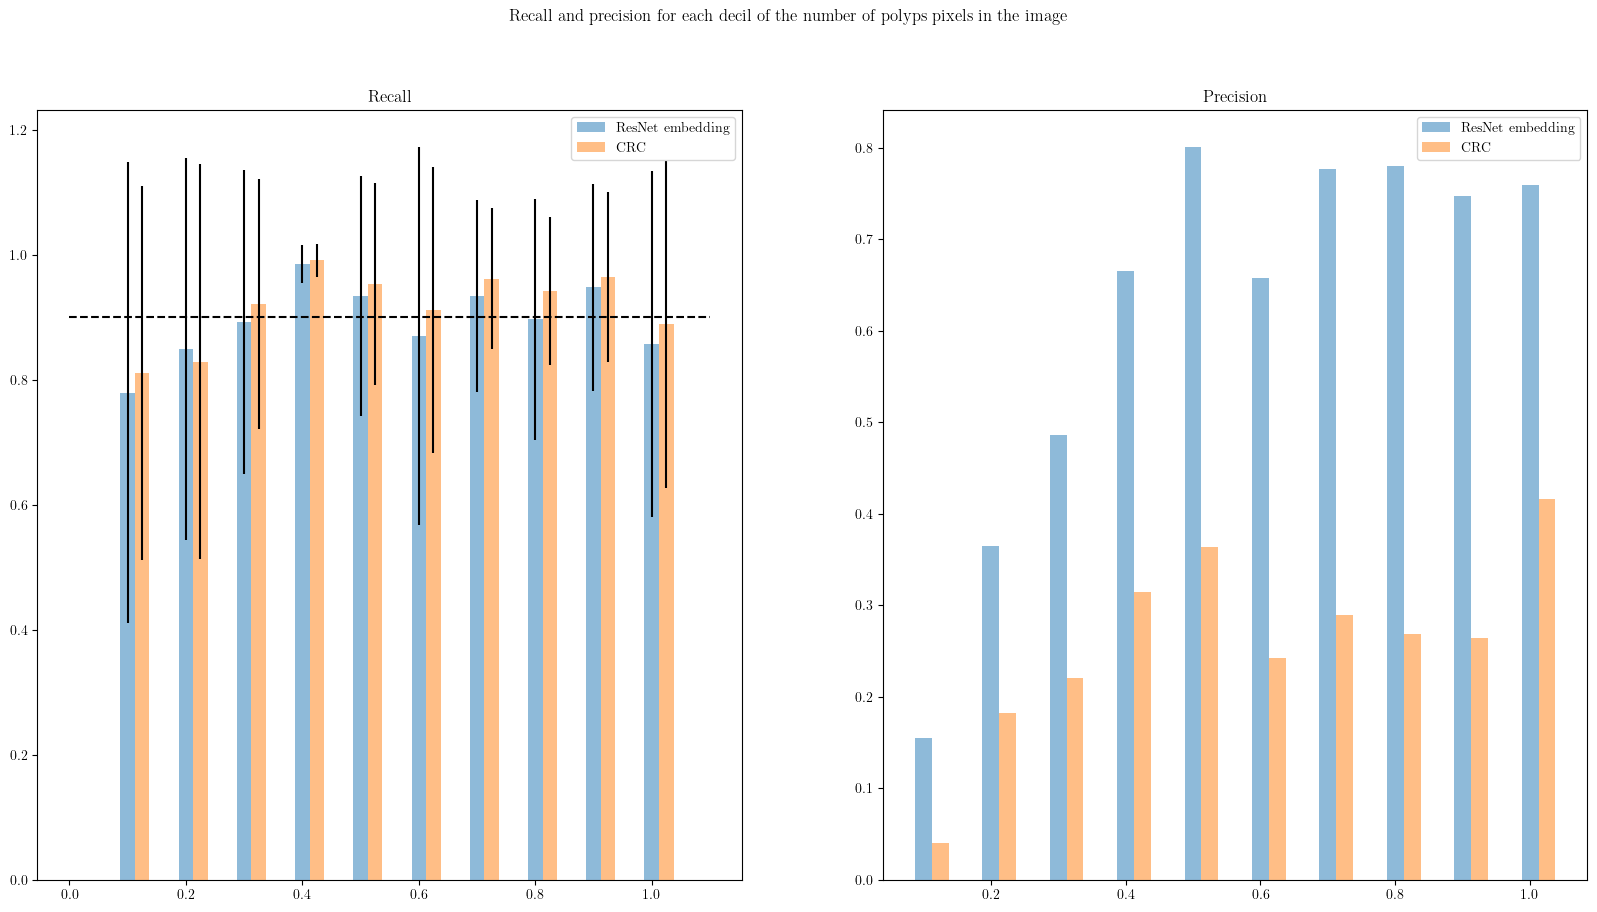

In [30]:
#check recall and precision for each bin for crc and resnet

mean_recall_resnet_bins = np.zeros(n_bins)
mean_recall_crc_bins = np.zeros(n_bins)
mean_precision_resnet_bins = np.zeros(n_bins)
mean_precision_crc_bins = np.zeros(n_bins)

std_recall_resnet_bins = np.zeros(n_bins)
std_recall_crc_bins = np.zeros(n_bins)
std_precision_resnet_bins = np.zeros(n_bins)
std_precision_crc_bins = np.zeros(n_bins)


for i in range(n_bins):
    if i == 0:
        index_bin = np.where(n_pixels <= bins[i])[0]
    else:
        index_bin = np.where((n_pixels > bins[i - 1]) & (n_pixels<= bins[i]))[0]
    y_pred_test_th_resnet = (test_pred_probas >= ths_res).astype(int)
    mean_recall_resnet_bins[i] = np.nanmean((y_pred_test_th_resnet[index_bin] * test_labels[index_bin]).sum(axis=(1, 2)) / test_labels[index_bin].sum(axis=(1, 2)))
    mean_precision_resnet_bins[i] = np.nanmean((y_pred_test_th_resnet[index_bin] * test_labels[index_bin]).sum(axis=(1, 2)) / y_pred_test_th_resnet[index_bin].sum(axis=(1, 2)))
    y_pred_test_th_crc = (test_pred_probas >= th_crc).astype(int)
    mean_recall_crc_bins[i] = np.nanmean((y_pred_test_th_crc[index_bin] * test_labels[index_bin]).sum(axis=(1, 2)) / test_labels[index_bin].sum(axis=(1, 2)))
    mean_precision_crc_bins[i] = np.nanmean((y_pred_test_th_crc[index_bin] * test_labels[index_bin]).sum(axis=(1, 2)) / y_pred_test_th_crc[index_bin].sum(axis=(1, 2)))

    std_recall_resnet_bins[i] = np.nanstd((y_pred_test_th_resnet[index_bin] * test_labels[index_bin]).sum(axis=(1, 2)) / test_labels[index_bin].sum(axis=(1, 2)))
    std_precision_resnet_bins[i] = np.nanstd((y_pred_test_th_resnet[index_bin] * test_labels[index_bin]).sum(axis=(1, 2)) / y_pred_test_th_resnet[index_bin].sum(axis=(1, 2)))
    std_recall_crc_bins[i] = np.nanstd((y_pred_test_th_crc[index_bin] * test_labels[index_bin]).sum(axis=(1, 2)) / test_labels[index_bin].sum(axis=(1, 2)))
    std_precision_crc_bins[i] = np.nanstd((y_pred_test_th_crc[index_bin] * test_labels[index_bin]).sum(axis=(1, 2)) / y_pred_test_th_crc[index_bin].sum(axis=(1, 2)))

s = 10
nrow = 1
ncol = 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s), squeeze=False)
width = 0.025
ax[0, 0].bar(np.linspace(.1, 1, n_bins), mean_recall_resnet_bins, yerr=std_recall_resnet_bins, width=width, label="ResNet embedding", alpha=.5)
ax[0, 0].bar(np.linspace(.1, 1, n_bins) + width, mean_recall_crc_bins, yerr=std_recall_crc_bins, width=width, label="CRC", alpha=.5)
# add error bars
# ax[0, 0].errorbar(np.linspace(.1, 1, 10), mean_recall_resnet_bins, yerr=std_recall_resnet_bins, fmt='o', color='black', label="ResNet embedding")

ax[0, 1].bar(np.linspace(.1, 1, n_bins), mean_precision_resnet_bins, width=width, label="ResNet embedding", alpha=.5)
ax[0, 1].bar(np.linspace(.1, 1, n_bins) + width, mean_precision_crc_bins, width=width, label="CRC", alpha=.5)

ax[0, 0].set_title("Recall")
ax[0, 1].set_title("Precision")

ax[0, 0].legend()
ax[0, 1].legend()

ax[0, 0].hlines(1 - ALPHA, 0, 1.1, color="black", linestyle="--")

plt.suptitle("Recall and precision for each decil of the number of polyps pixels in the image")
plt.show()



# Check conditionning wrt cluster

In [48]:
# Run kmeans cluster with 100 clusters on the embdeddings and then run CAH on the centroids to get 40 cluster

from sklearn.cluster import HDBSCAN, DBSCAN

In [73]:

test_cluster_labels_hdbscan = HDBSCAN(min_cluster_size=10, min_samples=1).fit_predict(test_res_emb)
test_cluster_labels_dbscan = DBSCAN(eps=.01, min_samples=100).fit_predict(test_res_emb)

In [74]:
len(np.unique(test_cluster_labels_hdbscan))

15

In [76]:
np.unique(test_cluster_labels_hdbscan, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([336,  10,  19,  14,  19,  11,  14,  26,  12,  12,  13,  13,  11,
         14,  22]))

In [78]:
# plot precision and recall for each cluster for crc and resnet
n_clusters = len(np.unique(test_cluster_labels_hdbscan))
mean_recall_resnet_clusters = np.zeros(n_clusters)
mean_recall_crc_clusters = np.zeros(n_clusters)
mean_precision_resnet_clusters = np.zeros(n_clusters)
mean_precision_crc_clusters = np.zeros(n_clusters)

std_recall_crc_clusters = np.zeros(n_clusters)
std_recall_resnet_clusters = np.zeros(n_clusters)
std_precision_crc_clusters = np.zeros(n_clusters)
std_precision_resnet_clusters = np.zeros(n_clusters)

/tmp/ipykernel_4134426/2932940779.py:5: RuntimeWarning: invalid value encountered in divide
  mean_precision_resnet_clusters[i] = np.nanmean((y_pred_test_th_resnet[index_cluster] * test_labels[index_cluster]).sum(axis=(1, 2)) / y_pred_test_th_resnet[index_cluster].sum(axis=(1, 2)))
/tmp/ipykernel_4134426/2932940779.py:11: RuntimeWarning: invalid value encountered in divide
  std_precision_resnet_clusters[i] = np.nanstd((y_pred_test_th_resnet[index_cluster] * test_labels[index_cluster]).sum(axis=(1, 2)) / y_pred_test_th_resnet[index_cluster].sum(axis=(1, 2)))
/tmp/ipykernel_4134426/2932940779.py:4: RuntimeWarning: Mean of empty slice
  mean_recall_resnet_clusters[i] = np.nanmean((y_pred_test_th_resnet[index_cluster] * test_labels[index_cluster]).sum(axis=(1, 2)) / test_labels[index_cluster].sum(axis=(1, 2)))
/tmp/ipykernel_4134426/2932940779.py:5: RuntimeWarning: Mean of empty slice
  mean_precision_resnet_clusters[i] = np.nanmean((y_pred_test_th_resnet[index_cluster] * test_labels[inde

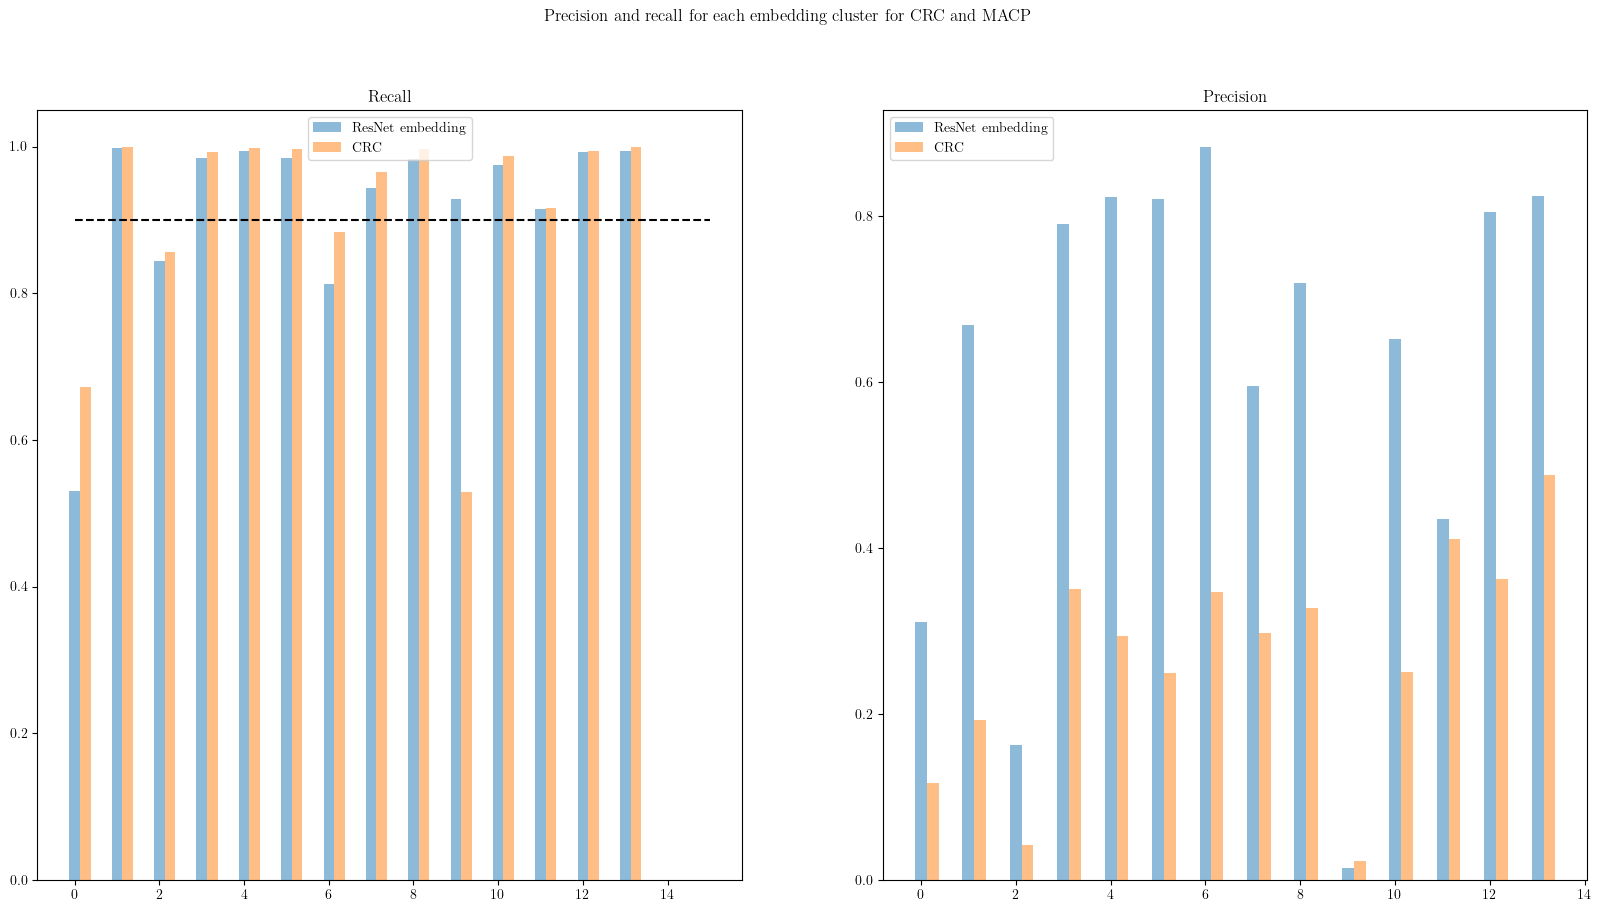

In [79]:

for i in range(n_clusters):
    index_cluster = np.where(test_cluster_labels_hdbscan == i)[0]
    y_pred_test_th_resnet = (test_pred_probas >= ths_res).astype(int)
    mean_recall_resnet_clusters[i] = np.nanmean((y_pred_test_th_resnet[index_cluster] * test_labels[index_cluster]).sum(axis=(1, 2)) / test_labels[index_cluster].sum(axis=(1, 2)))
    mean_precision_resnet_clusters[i] = np.nanmean((y_pred_test_th_resnet[index_cluster] * test_labels[index_cluster]).sum(axis=(1, 2)) / y_pred_test_th_resnet[index_cluster].sum(axis=(1, 2)))
    y_pred_test_th_crc = (test_pred_probas >= th_crc).astype(int)
    mean_recall_crc_clusters[i] = np.nanmean((y_pred_test_th_crc[index_cluster] * test_labels[index_cluster]).sum(axis=(1, 2)) / test_labels[index_cluster].sum(axis=(1, 2)))
    mean_precision_crc_clusters[i] = np.nanmean((y_pred_test_th_crc[index_cluster] * test_labels[index_cluster]).sum(axis=(1, 2)) / y_pred_test_th_crc[index_cluster].sum(axis=(1, 2)))

    std_recall_resnet_clusters[i] = np.nanstd((y_pred_test_th_resnet[index_cluster] * test_labels[index_cluster]).sum(axis=(1, 2)) / test_labels[index_cluster].sum(axis=(1, 2)))
    std_precision_resnet_clusters[i] = np.nanstd((y_pred_test_th_resnet[index_cluster] * test_labels[index_cluster]).sum(axis=(1, 2)) / y_pred_test_th_resnet[index_cluster].sum(axis=(1, 2)))
    std_recall_crc_clusters[i] = np.nanstd((y_pred_test_th_crc[index_cluster] * test_labels[index_cluster]).sum(axis=(1, 2)) / test_labels[index_cluster].sum(axis=(1, 2)))
    std_precision_crc_clusters[i] = np.nanstd((y_pred_test_th_crc[index_cluster] * test_labels[index_cluster]).sum(axis=(1, 2)) / y_pred_test_th_crc[index_cluster].sum(axis=(1, 2)))



s = 10
nrow = 1
ncol = 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s), squeeze=False)
width = 0.25
ax[0, 0].bar(np.arange(n_clusters), mean_recall_resnet_clusters, yerr=None, width=width, label="ResNet embedding", alpha=.5)
ax[0, 0].bar(np.arange(n_clusters) + width, mean_recall_crc_clusters, yerr=None, width=width, label="CRC", alpha=.5)

ax[0, 1].bar(np.arange(n_clusters), mean_precision_resnet_clusters, width=width, label="ResNet embedding", alpha=.5)
ax[0, 1].bar(np.arange(n_clusters) + width, mean_precision_crc_clusters, width=width, label="CRC", alpha=.5)

ax[0, 0].set_title("Recall")
ax[0, 1].set_title("Precision")

ax[0, 0].legend()
ax[0, 1].legend()

ax[0, 0].hlines(1 - ALPHA, 0, n_clusters, color="black", linestyle="--")

plt.suptitle("Precision and recall for each embedding cluster for CRC and MACP")
plt.show()
                                           



In [35]:
np.nanmean((y_pred_test_th_resnet[index_bin] * test_labels[index_bin]).sum(axis=(1, 2)) / test_labels[index_bin].sum(axis=(1, 2)))

0.8883374825280821

In [43]:
# count number of polyps in each image and plot precision and recall for each number of polyps

n_polyps = []

img_names = sorted(os.listdir(DIR_TEST_LABELS))
for i, img_name in enumerate(img_names):
    label = cv2.imread(os.path.join(DIR_TEST_LABELS, img_name), cv2.IMREAD_GRAYSCALE) // 255
    # count number of connected components
    n_elemnts = 0
    for element in cv2.connectedComponentsWithStats(label.astype(np.uint8), 4, cv2.CV_32S)[2]:
        if element[4] > 10:
            n_elemnts += 1
    n_polyps.append(n_elemnts)


In [44]:
np.max(n_polyps)

4

In [66]:
plt.imshow(cv2.imread(os.path.join(DIR_TEST_LABELS, img_names[np.argmax(n_polyps)]), cv2.IMREAD_GRAYSCALE) // 255)

NameError: name 'img_names' is not defined

/tmp/ipykernel_1562567/448378373.py:11: RuntimeWarning: Mean of empty slice
  recall_resnet_polyps[i] = np.nanmean((y_pred_test_th_resnet[index_polyps] * test_labels[index_polyps]).sum(axis=(1, 2)) / test_labels[index_polyps].sum(axis=(1, 2)))
/tmp/ipykernel_1562567/448378373.py:12: RuntimeWarning: Mean of empty slice
  precision_resnet_polyps[i] = np.nanmean((y_pred_test_th_resnet[index_polyps] * test_labels[index_polyps]).sum(axis=(1, 2)) / y_pred_test_th_resnet[index_polyps].sum(axis=(1, 2)))
/tmp/ipykernel_1562567/448378373.py:14: RuntimeWarning: Mean of empty slice
  recall_crc_polyps[i] = np.nanmean((y_pred_test_th_crc[index_polyps] * test_labels[index_polyps]).sum(axis=(1, 2)) / test_labels[index_polyps].sum(axis=(1, 2)))
/tmp/ipykernel_1562567/448378373.py:15: RuntimeWarning: Mean of empty slice
  precision_crc_polyps[i] = np.nanmean((y_pred_test_th_crc[index_polyps] * test_labels[index_polyps]).sum(axis=(1, 2)) / y_pred_test_th_crc[index_polyps].sum(axis=(1, 2)))
/tmp/ipykerne

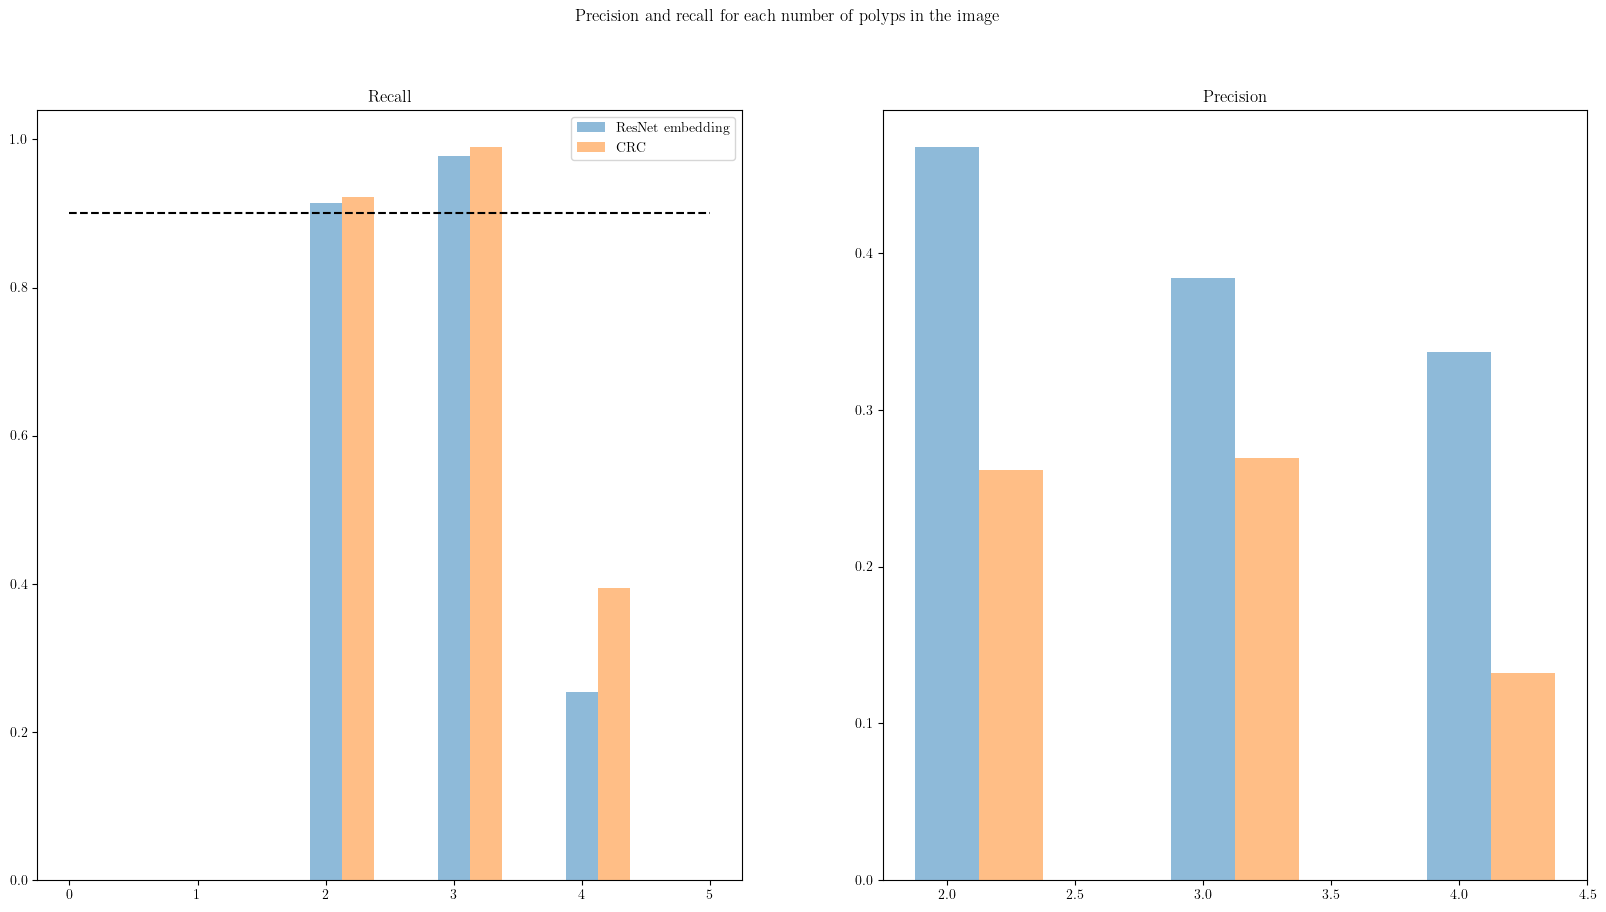

In [46]:
# plot precision and recall for each number of polyps for crc and resnet

recall_resnet_polyps = np.zeros(np.max(n_polyps) + 1)
recall_crc_polyps = np.zeros(np.max(n_polyps) + 1)
precision_resnet_polyps = np.zeros(np.max(n_polyps) + 1)
precision_crc_polyps = np.zeros(np.max(n_polyps) + 1)

for i in range(np.max(n_polyps) + 1):
    index_polyps = np.where(np.array(n_polyps) == i)[0]
    y_pred_test_th_resnet = (test_pred_probas >= ths_res).astype(int)
    recall_resnet_polyps[i] = np.nanmean((y_pred_test_th_resnet[index_polyps] * test_labels[index_polyps]).sum(axis=(1, 2)) / test_labels[index_polyps].sum(axis=(1, 2)))
    precision_resnet_polyps[i] = np.nanmean((y_pred_test_th_resnet[index_polyps] * test_labels[index_polyps]).sum(axis=(1, 2)) / y_pred_test_th_resnet[index_polyps].sum(axis=(1, 2)))
    y_pred_test_th_crc = (test_pred_probas >= th_crc).astype(int)
    recall_crc_polyps[i] = np.nanmean((y_pred_test_th_crc[index_polyps] * test_labels[index_polyps]).sum(axis=(1, 2)) / test_labels[index_polyps].sum(axis=(1, 2)))
    precision_crc_polyps[i] = np.nanmean((y_pred_test_th_crc[index_polyps] * test_labels[index_polyps]).sum(axis=(1, 2)) / y_pred_test_th_crc[index_polyps].sum(axis=(1, 2)))


s = 10
nrow = 1
ncol = 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s), squeeze=False)
width = 0.25
ax[0, 0].bar(np.arange(np.max(n_polyps) + 1), recall_resnet_polyps, width=width, label="ResNet embedding", alpha=.5)
ax[0, 0].bar(np.arange(np.max(n_polyps) + 1) + width, recall_crc_polyps, width=width, label="CRC", alpha=.5)

ax[0, 1].bar(np.arange(np.max(n_polyps) + 1), precision_resnet_polyps, width=width, label="ResNet embedding", alpha=.5)
ax[0, 1].bar(np.arange(np.max(n_polyps) + 1) + width, precision_crc_polyps, width=width, label="CRC", alpha=.5)

ax[0, 0].set_title("Recall")
ax[0, 1].set_title("Precision")

ax[0, 0].legend()

ax[0, 0].hlines(1 - ALPHA, 0, np.max(n_polyps) + 1, color="black", linestyle="--")

plt.suptitle("Precision and recall for each number of polyps in the image")

plt.show()

In [127]:
# plot precision and recall for each decile of the ths_res for crc and resnet

mean_recall_resnet_ths = np.zeros(10)
mean_recall_crc_ths = np.zeros(10)
mean_precision_resnet_ths = np.zeros(10)
mean_precision_crc_ths = np.zeros(10)

std_recall_resnet_ths = np.zeros(10)
std_recall_crc_ths = np.zeros(10)
std_precision_resnet_ths = np.zeros(10)
std_precision_crc_ths = np.zeros(10)


n_bins = 10
bins_ths = np.linspace(0.1, 1, n_bins)
bins_ths = np.quantile(ths_res[:, 0, 0], bins_ths)
bins_ths


for i in tqdm(range(10)):
    if i == 0:
        index_bin = np.where(ths_res[:, 0, 0] <= bins_ths[i])[0]
    else:
        index_bin = np.where((ths_res[:, 0, 0] > bins_ths[i - 1]) & (ths_res[:, 0, 0]<= bins_ths[i]))[0]

    ths_res_index_bin = ths_res[index_bin]

    y_pred_test_th_resnet = (test_pred_probas[index_bin] >= ths_res_index_bin).astype(int)

    good_predictions_resnet = (y_pred_test_th_resnet * test_labels[index_bin]).sum(axis=(1, 2))
    good_predictions_crc = (y_pred_test_th_crc[index_bin] * test_labels[index_bin]).sum(axis=(1, 2))

    sum_labels = test_labels[index_bin].sum(axis=(1, 2))
    sum_pred_resnet = y_pred_test_th_resnet.sum(axis=(1, 2)) 
    sum_pred_crc = y_pred_test_th_crc[index_bin].sum(axis=(1, 2))

    y_pred_test_th_crc = (test_pred_probas >= th_crc).astype(int)

    mean_recall_resnet_ths[i] = np.nanmean(good_predictions_resnet / sum_labels)
    mean_precision_resnet_ths[i] = np.nanmean(good_predictions_resnet / sum_pred_resnet)
    mean_recall_crc_ths[i] = np.nanmean(good_predictions_crc / sum_labels)
    mean_precision_crc_ths[i] = np.nanmean(good_predictions_crc / sum_pred_crc)

    std_recall_resnet_ths[i] = np.nanstd(good_predictions_resnet / sum_labels)
    std_precision_resnet_ths[i] = np.nanstd(good_predictions_resnet / sum_pred_resnet)
    std_recall_crc_ths[i] = np.nanstd(good_predictions_crc / sum_labels)
    std_precision_crc_ths[i] = np.nanstd(good_predictions_crc / sum_pred_crc)





  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:21<00:21,  4.25s/it]/tmp/ipykernel_1562567/1918501337.py:40: RuntimeWarning: invalid value encountered in divide
  mean_precision_resnet_ths[i] = np.nanmean(good_predictions_resnet / sum_pred_resnet)
/tmp/ipykernel_1562567/1918501337.py:45: RuntimeWarning: invalid value encountered in divide
  std_precision_resnet_ths[i] = np.nanstd(good_predictions_resnet / sum_pred_resnet)
100%|██████████| 10/10 [00:42<00:00,  4.26s/it]


In [129]:
std_recall_resnet_bins.shape

(5,)

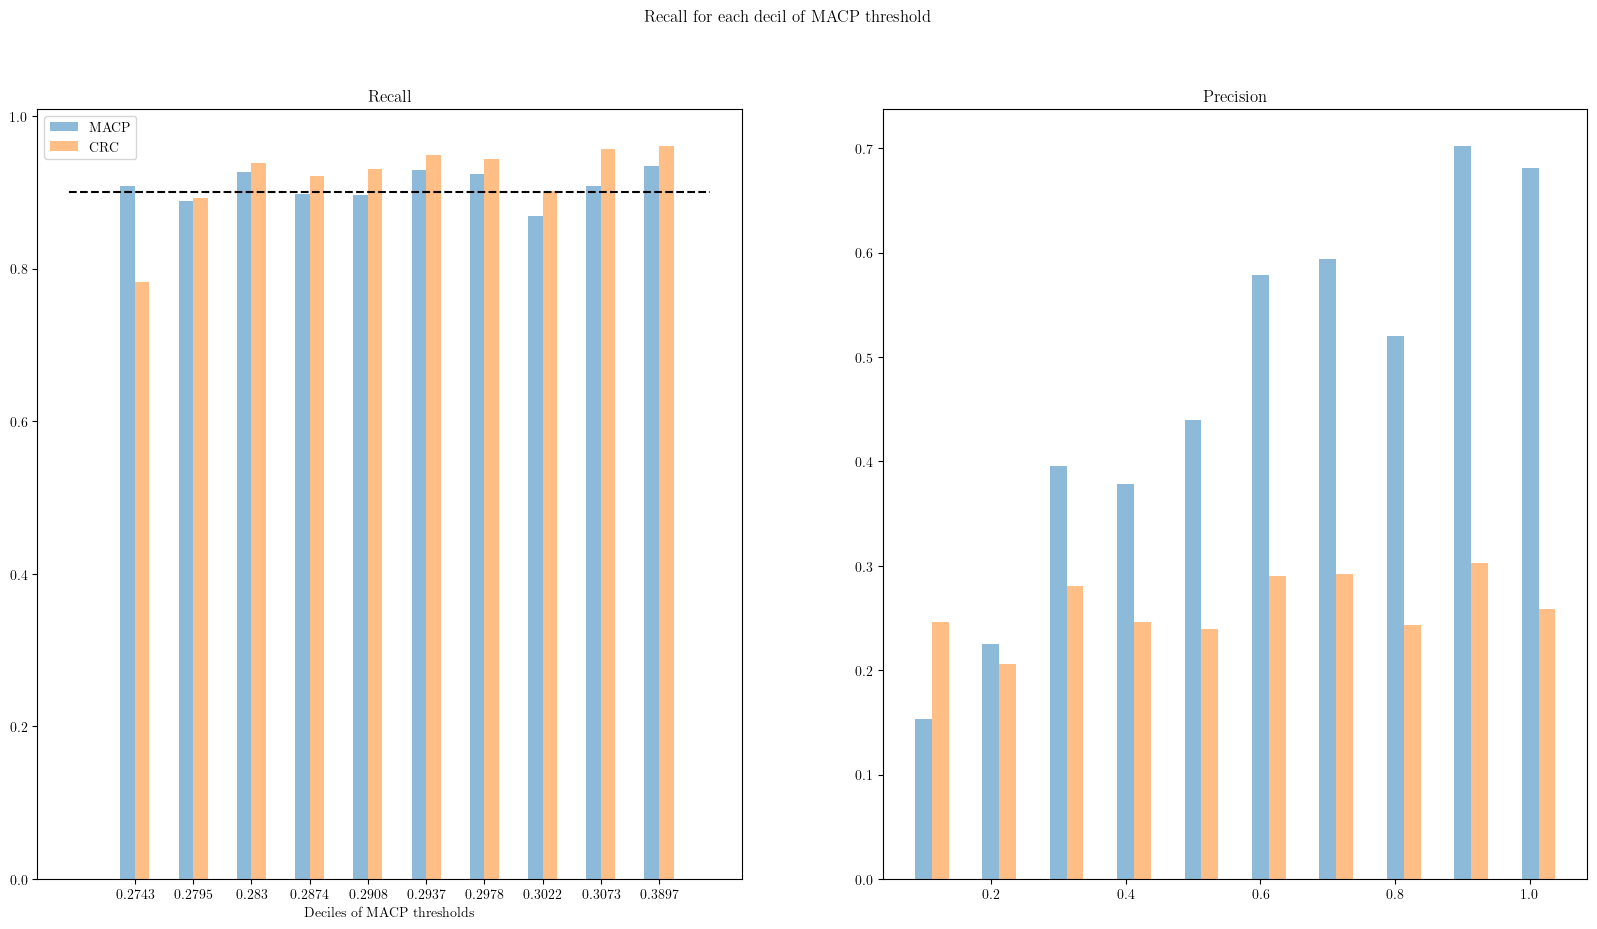

In [145]:
s = 10
nrow = 1
ncol = 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s), squeeze=False)
width = 0.025
nbins = 10
ax[0, 0].bar(np.linspace(.1, 1, n_bins), mean_recall_resnet_ths, yerr=None, width=width, label="MACP", alpha=.5)
ax[0, 0].bar(np.linspace(.1, 1, n_bins) + width, mean_recall_crc_ths, yerr=None, width=width, label="CRC", alpha=.5)
# ax[0, 0].bar_label(bins_ths)
# add error bars
# ax[0, 0].errorbar(np.linspace(.1, 1, 10), mean_recall_resnet_bins, yerr=std_recall_resnet_bins, fmt='o', color='black', label="ResNet embedding")
ax[0, 0].set_xticks(np.linspace(.1, 1, n_bins) + width / 2, np.round(bins_ths, 4))
ax[0, 1].bar(np.linspace(.1, 1, n_bins), mean_precision_resnet_ths, width=width, label="ResNet embedding", alpha=.5)
ax[0, 1].bar(np.linspace(.1, 1, n_bins) + width, mean_precision_crc_ths, width=width, label="CRC", alpha=.5)

ax[0, 0].set_title("Recall")
ax[0, 1].set_title("Precision")

ax[0, 0].legend()
# ax[0, 1].legend()

ax[0, 0].hlines(1 - ALPHA, 0, 1.1, color="black", linestyle="--")
ax[0, 0].set_xlabel("Deciles of MACP thresholds")

plt.suptitle("Recall for each decil of MACP threshold")
plt.show()

In [ ]:
s = 10

nrow = 1
ncol = 2

f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s), squeeze=False)

width = 0.25
ax[0, 0].bar(np.arange(10), mean_recall_resnet_ths, yerr=std_recall_resnet_ths, width=width, label="ResNet embedding", alpha=.5)
ax[0, 0].bar(np.arange(10) + width, mean_recall_crc_ths, yerr=std_recall_crc_ths, width=width, label="CRC", alpha=.5)

ax[0, 1].bar(np.arange(10), mean_precision_resnet_ths, yerr=std_precision_resnet_ths, width=width, label="ResNet embedding", alpha=.5)
ax[0, 1].bar(np.arange(10) + width, mean_precision_crc_ths, yerr=std_precision_crc_ths, width=width, label="CRC", alpha=.5)

ax[0, 0].set_title("Recall")
ax[0, 1].set_title("Precision")

ax[0, 0].legend()
ax[0, 1].legend()

ax[0, 0].hlines(1 - ALPHA, 0, 10, color="black", linestyle="--")

plt.suptitle("Precision and recall for each decile of the threshold for the ResNet embedding")

# Check distance to real threshold

In [96]:
from multiaccurate_cp.utils.ml_utils import get_threshold

In [98]:
true_thresholds =[]
for i in range(len(test_pred_probas)):
    true_thresholds.append(get_threshold(test_pred_probas[i], test_labels[i], 1 - ALPHA))

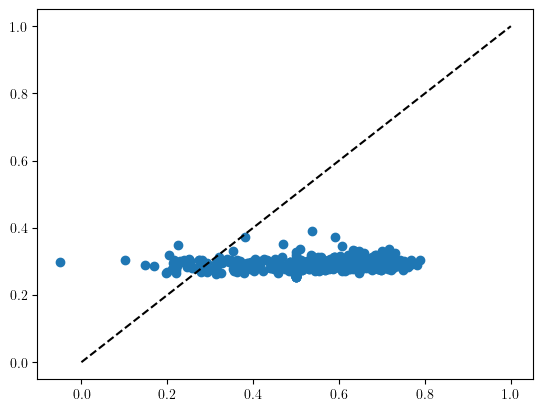

In [106]:
plt.scatter(true_thresholds, ths_res[:, 0, 0])
plt.plot([0, 1], [0, 1], color="black", linestyle="--")